In [1]:
import pandas as pd
import pyarrow.parquet as pq
from numpy import nan

# CLean
## Creat a static dictionary for useful columns

## Clean and extract windmill data

In [ ]:
# static cols
cols = ['GSRN','Turbine_type','Parent_GSRN','BBR_municipal','Placement','UTM_x','UTM_y','Capacity_kw','Rotor_diameter','Navhub_height']

In [ ]:
windmills = pq.read_table('data/ITU_DATA/masterdatawind.parquet').to_pandas()[cols]
windmills.shape

Windmills have duplicated data by different reviewers.    
Remove duplicated data

In [ ]:
windmills.drop_duplicates(subset = "GSRN", keep = 'first', ignore_index = True, inplace = True)
windmills.shape

9853 Contains:    
- H: Household turbine : No UTM_xy locations 
- W: Single turbine : full data
- P: Turbine park : No UTM_xy locations
- M: Turbine in a park : No power record in settlement data


In [ ]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)

Fill Turbine park xy by calculate their CENTRIODs.

In [ ]:
aggs = {'UTM_x':lambda x : x.mean(),
        'UTM_y':lambda x : x.mean()}
w_temp = windmills[windmills['Turbine_type'] == 'M'].groupby(['Parent_GSRN'], as_index = False).agg(aggs).rename(columns={'Parent_GSRN':'GSRN','UTM_x':'x_c','UTM_y':'y_c'})
w_temp

578 != 444    
Fill some missing turbine parks

In [ ]:
f = windmills[windmills['Turbine_type'] == 'P']

In [ ]:
f[f['GSRN'].isin(w_temp['GSRN'])]

In [ ]:
f[~f['GSRN'].isin(w_temp['GSRN'])]

In [ ]:
w_temp[~w_temp['GSRN'].isin(f['GSRN'])]

Fill 136 in to windmills

In [ ]:
windmills.shape

In [ ]:
windmills = pd.merge(windmills, w_temp, on='GSRN', how='outer')
# location
windmills[['UTM_x']] = windmills.apply(lambda x: x[['UTM_x']].fillna(value = x['x_c']), axis=1)[['UTM_x']]
windmills[['UTM_y']] = windmills.apply(lambda x: x[['UTM_y']].fillna(value = x['y_c']), axis=1)[['UTM_y']]
windmills.drop(columns=['x_c','y_c'], inplace=True)
# Turbine type
windmills['Turbine_type'].fillna('P', inplace = True)
windmills

Cause a bug in ArcGIS file import, we need to add a 'z' at the end of GSRN and Parent_GSRN

In [ ]:
windmills['GSRN'] = [x+'z' for x in windmills['GSRN']]
windmills['Parent_GSRN'].fillna('',inplace = True)
windmills['Parent_GSRN'] = [x+'z' for x in windmills['Parent_GSRN']]
windmills

In [ ]:
windmills.to_csv('data/windmills_gis.csv', index=False)

After ArcGIS    
1. Single grid

In [ ]:
windmills_single_grid= pd.read_excel('data/windmills_to_single-grid.xlsx')[['GSRN','grid']]
windmills_single_grid['grid'].fillna(value=0, inplace = True)
windmills_single_grid['grid'] = windmills_single_grid['grid'].astype(int)
windmills_single_grid['grid'] = windmills_single_grid['grid'].astype(str)
windmills = pd.merge(windmills, windmills_single_grid, on='GSRN', how='left')
windmills

In [ ]:
windmills_multi_grid = pd.read_excel('data/windmills_to_multi-grid.xlsx')[['GSRN','grid']]
windmills_multi_grid['grid'].fillna(value=0, inplace = True)
windmills_multi_grid['grid'] = windmills_multi_grid['grid'].astype(int)
windmills_multi_grid['grid'] = windmills_multi_grid['grid'].astype(str)

In [ ]:
def ab(df):
    return','.join(df.values)
    
windmills_multi_grid = windmills_multi_grid.groupby('GSRN')['grid'].apply(ab).reset_index().rename(columns={'grid':'grid_in_range'})
windmills = pd.merge(windmills, windmills_multi_grid, on='GSRN', how='left')
windmills

In [ ]:
windmills.to_csv('data/windmill_cleaned.csv')

In [ ]:
windmills = pd.read_csv('data/windmill_cleaned.csv',sep=';')
windmills_lc_slope = pd.read_excel('data/windmills_lc_slope.xlsx')

In [ ]:
windmills_lc_slope['Land_cover'].fillna(value=-1, inplace = True)
windmills_lc_slope['Slope'].fillna(value=-1, inplace = True)

In [ ]:
roughness_dic = {210:0.0, 220:0.004, 200:0.005, 202:0.005, 140:0.03, 150:0.05, 11:0.1, 14:0.1, 130:0.1, 180:11, 10:0.1, 20:0.3, 30:0.3, 160:0.5, 120:0.5, 170:0.6, 190:1.0, 40:1.5, 50:1.5, 60:1.5, 70:1.5, 90:1.5, 100:1.5, 110:1.5, -1:0.0}

windmills_lc_slope['roughness'] = windmills_lc_slope['Land_cover'].apply(lambda x: roughness_dic[x])

In [ ]:
windmills_lc_slope

In [ ]:
windmills_lc_slope

In [ ]:
windmills = pd.merge(windmills, windmills_lc_slope, on='GSRN', how='left')

In [ ]:
windmills = windmills.drop(index=0)

In [ ]:
windmills

In [ ]:
windmills.to_csv('data/windmill_cleaned.csv',index=False)

## Weather Grid Observation

In [ ]:
weather_grids = pd.read_csv('data/ITU_DATA/prognosis/grid_coordinates.csv') 
print(len(weather_grids))
weather_grids.head(10)

## Data in Observations
We don't have the join table of municipal names and ids.

In [3]:
observed_wind_speed_gust = pq.read_table('data/ITU_DATA/observations/observed_wind_speed_gust.parquet').to_pandas()

In [5]:
print(len(observed_wind_speed_gust))
observed_wind_speed_gust.head(10)

22874670


,municipal,subtype,value,unit
timestamp_utc,,,,
2015-01-11 00:00:00,Allerød,Time højeste 3-sekunders vindhastighed,24.600000,m/s
2015-01-11 02:00:00,Assens,Time højeste 3-sekunders vindhastighed,22.799999,m/s
2015-01-11 13:00:00,Assens,Time højeste 3-sekunders vindhastighed,0.000000,m/s
2015-01-11 04:00:00,Ballerup,Time højeste 3-sekunders vindhastighed,23.000000,m/s
2015-01-11 10:00:00,Brønderslev,Time højeste 3-sekunders vindhastighed,21.400000,m/s
2015-01-11 19:00:00,Brønderslev,Time højeste 3-sekunders vindhastighed,17.799999,m/s
2015-01-11 08:00:00,Esbjerg,Time højeste 3-sekunders vindhastighed,25.200001,m/s
2015-01-11 19:00:00,Hvidovre,Time højeste 3-sekunders vindhastighed,16.900000,m/s
2015-01-11 16:00:00,Kalundborg,Time højeste 3-sekunders vindhastighed,23.299999,m/s


In [6]:
observed_wind_speed_high10 = pq.read_table('data/ITU_DATA/observations/observed_wind_speed_high10.parquet').to_pandas()
print(len(observed_wind_speed_high10))
observed_wind_speed_high10.head(10)

22890252


,municipal,subtype,value,unit
timestamp_utc,,,,
2012-05-28 23:00:00,Aabenraa,Time højeste 10-minutters vindhastighed,5.9,m/s
2012-05-29 02:00:00,Aabenraa,Time højeste 10-minutters vindhastighed,7.3,m/s
2012-05-29 21:00:00,Brønderslev,Time højeste 10-minutters vindhastighed,3.7,m/s
2012-05-29 13:00:00,Gribskov,Time højeste 10-minutters vindhastighed,4.5,m/s
2012-05-29 14:00:00,Holstebro,Time højeste 10-minutters vindhastighed,8.3,m/s
2012-05-29 05:00:00,Hørsholm,Time højeste 10-minutters vindhastighed,4.3,m/s
2012-05-29 08:00:00,Roskilde,Time højeste 10-minutters vindhastighed,6.9,m/s
2012-05-29 07:00:00,Solrød,Time højeste 10-minutters vindhastighed,6.2,m/s
2013-05-23 08:00:00,Brøndby,Time højeste 10-minutters vindhastighed,6.0,m/s


## progbisis ENetNEA
resolution in 1 hour    
data from this model since 2018-02-22.

In [ ]:
wind_speed_10m = pq.read_table('data/ITU_DATA/prognosis/ENetNEA/wind_speed_10m.parquet').to_pandas().reset_index()

In [ ]:
wind_speed_10m.head()

In [ ]:
wind_speed_10m = wind_speed_10m.drop_duplicated(['index'], keep = last)

In [ ]:
wind_speed_10m['index'] = wind_speed_10m['index'].astype(str)
wind_speed_10m[['date','time']] = wind_speed_10m['index'].str.split(' ', expand = True)
   

In [ ]:
wind_direction_10m = pq.read_table('data/ITU_DATA/prognosis/ENetNEA/wind_direction_10m.parquet').to_pandas().reset_index()

In [ ]:
wind_direction_10m.head(30)

In [7]:
temperatur_2m = pq.read_table('data/ITU_DATA/prognosis/ENetNEA/temperatur_2m.parquet').to_pandas().reset_index()

In [8]:
temperatur_2m.head(10)

,index,190,191,231,232,233,273,274,275,314,...,1412,1413,1445,1446,1447,1448,1449,1450,1451,predicted_ahead
0,2018-02-22 00:00:00,274.3,274.1,274.4,272.9,273.7,274.2,272.8,272.1,275.1,...,276.8,275.6,277.3,277.7,278.0,277.7,277.9,277.7,277.6,1
1,2018-02-22 01:00:00,274.3,274.1,274.4,271.8,273.5,274.3,272.7,271.6,274.6,...,275.3,275.3,277.5,277.8,278.0,278.1,277.8,277.7,277.5,2
2,2018-02-22 02:00:00,274.3,274.1,274.4,272.3,273.5,274.3,273.0,271.5,274.6,...,274.8,275.2,277.7,277.8,278.0,277.9,277.7,277.7,277.4,3
3,2018-02-22 03:00:00,274.1,274.1,274.4,272.1,273.4,274.4,273.0,271.2,274.6,...,274.6,275.0,277.6,277.8,277.9,277.8,277.7,277.6,277.3,4
4,2018-02-22 04:00:00,274.2,274.0,274.4,271.3,273.3,274.4,272.2,270.9,274.7,...,274.3,274.9,277.4,277.9,277.8,277.7,277.6,277.4,277.0,5
5,2018-02-22 05:00:00,274.1,274.0,274.3,270.8,273.3,274.1,271.6,270.8,274.7,...,274.1,274.5,277.4,277.8,277.7,277.7,277.5,276.9,275.4,6
6,2018-02-22 06:00:00,274.1,274.0,274.2,270.6,273.5,274.1,271.5,271.0,274.4,...,274.0,274.4,277.6,277.7,277.7,277.6,277.1,275.5,275.1,7
7,2018-02-22 07:00:00,274.1,273.8,274.2,270.7,273.3,274.1,271.6,271.0,274.3,...,273.9,274.4,277.6,277.6,277.7,277.5,275.8,275.2,274.9,8
8,2018-02-22 08:00:00,273.8,273.7,274.3,272.0,273.5,274.1,272.6,272.6,274.3,...,273.9,274.2,277.6,277.6,277.6,276.4,275.6,274.9,274.9,9
9,2018-02-22 09:00:00,273.9,273.6,274.1,273.4,273.5,273.7,273.2,273.0,274.4,...,274.0,274.2,277.5,277.5,276.6,276.0,275.1,274.6,274.8,10


In [9]:
temperatur_100m = pq.read_table('data/ITU_DATA/prognosis/ENetNEA/temperatur_100m.parquet').to_pandas().reset_index()

In [10]:
temperatur_100m.head(10)

,index,190,191,231,232,233,273,274,275,314,...,1412,1413,1445,1446,1447,1448,1449,1450,1451,predicted_ahead
0,2018-02-22 00:00:00,273.1,273.0,273.3,272.5,272.8,273.1,272.6,272.0,274.0,...,276.2,274.6,276.3,276.8,277.3,277.2,277.3,277.0,276.8,1
1,2018-02-22 01:00:00,273.2,273.1,273.4,272.5,272.8,273.2,272.6,272.1,273.5,...,274.4,274.2,276.6,277.0,277.3,277.3,277.0,276.9,276.7,2
2,2018-02-22 02:00:00,273.2,273.0,273.4,272.6,272.9,273.2,272.8,272.2,273.5,...,273.6,274.0,276.8,277.0,277.2,277.1,276.9,276.8,276.6,3
3,2018-02-22 03:00:00,273.0,273.0,273.4,272.5,272.8,273.3,272.7,272.2,273.5,...,273.4,273.9,276.7,277.1,277.1,277.0,276.8,276.7,276.4,4
4,2018-02-22 04:00:00,273.0,272.9,273.3,272.5,272.7,273.3,272.6,272.2,273.6,...,273.1,273.7,276.7,277.0,277.0,276.9,276.8,276.6,276.1,5
5,2018-02-22 05:00:00,273.0,272.9,273.2,272.5,272.7,273.0,272.6,272.1,273.6,...,273.0,273.3,276.7,276.9,276.9,276.8,276.7,276.0,274.3,6
6,2018-02-22 06:00:00,273.0,272.9,273.1,272.5,272.7,273.0,272.7,272.1,273.3,...,272.8,273.3,276.8,276.8,276.8,276.7,276.2,274.5,274.0,7
7,2018-02-22 07:00:00,273.0,272.6,273.1,272.5,272.3,273.0,272.7,271.8,273.2,...,272.7,273.3,276.8,276.8,276.8,276.5,274.8,274.1,273.8,8
8,2018-02-22 08:00:00,272.7,272.6,273.2,272.1,272.4,273.0,272.0,271.8,273.2,...,272.8,273.1,276.8,276.7,276.7,275.4,274.5,273.8,273.8,9
9,2018-02-22 09:00:00,272.7,272.5,272.9,272.3,272.3,272.5,272.3,271.7,273.3,...,272.9,273.1,276.6,276.6,275.8,274.9,274.0,273.4,273.7,10


## Settlement
resolution in 15 mins

In [ ]:
import pyspark

In [ ]:
settlement_2018 = spark.read.parquet('data/ITU_DATA/settlement/2018.parquet')

In [ ]:
settlement_2018 = pq.read_table('data/ITU_DATA/settlement/2018.parquet').to_pandas()

In [ ]:
settlement_2018 = settlement_2018[settlement_2018.TIME_CET.str.contains(':00:')].reset_index()

In [ ]:
settlement_2018.head()

# A single windmill

In [44]:
import pandas as pd
from numpy import nan
import matplotlib.pyplot as plt

In [100]:
windmills = pd.read_csv('data/windmill_cleaned.csv')
windmills.fillna(nan)

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,grid,grid_in_range,Land_cover,Slope,roughness
0,570714700000000027,M,5.707147e+17,101.0,LAND,720898.353000,6171174.877,225.0,27.0,30.0,653,"651,693,610,736,695,737,611,653,694,654,652,69...",210.0,3.646971,0.0
1,570714700000000034,M,5.707147e+17,101.0,LAND,720993.352000,6171226.877,225.0,27.0,30.0,653,"651,693,610,736,695,737,611,653,694,654,652,69...",100.0,1.012750,1.5
2,570714700000000041,M,5.707147e+17,101.0,LAND,727504.304000,6178385.864,600.0,44.0,50.0,653,"651,693,610,695,737,611,653,694,654,652,696,60...",210.0,8.111279,0.0
3,570714700000000058,M,5.707147e+17,101.0,LAND,727628.303000,6178385.865,600.0,44.0,50.0,653,"651,693,610,695,737,611,653,694,654,652,696,60...",210.0,5.051153,0.0
4,570714700000000065,M,5.707147e+17,101.0,LAND,727817.302000,6178365.866,600.0,44.0,50.0,653,"651,693,610,695,611,653,694,654,652,696,609,65...",210.0,5.885129,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,570715000000055638,P,NaN,NaN,NaN,504163.000000,6277061.000,NaN,NaN,NaN,1243,"1283,1241,1326,1285,1284,1199,1158,1242,1202,1...",70.0,2.263636,1.5
9978,570715000000056017,P,NaN,NaN,NaN,468672.240000,6145816.035,NaN,NaN,NaN,1235,"1233,1191,1275,1195,1318,1276,1235,1192,1150,1...",10.0,0.000000,0.1
9979,570715000000056857,P,NaN,NaN,NaN,513111.100000,6320199.400,NaN,NaN,NaN,1246,"1202,1244,1330,1331,1329,1245,1328,1286,1246,1...",130.0,1.432096,0.1
9980,570715000000056918,P,NaN,NaN,NaN,514683.070000,6320302.490,NaN,NaN,NaN,1246,"1202,1244,1330,1331,1329,1245,1328,1286,1246,1...",130.0,0.000000,0.1


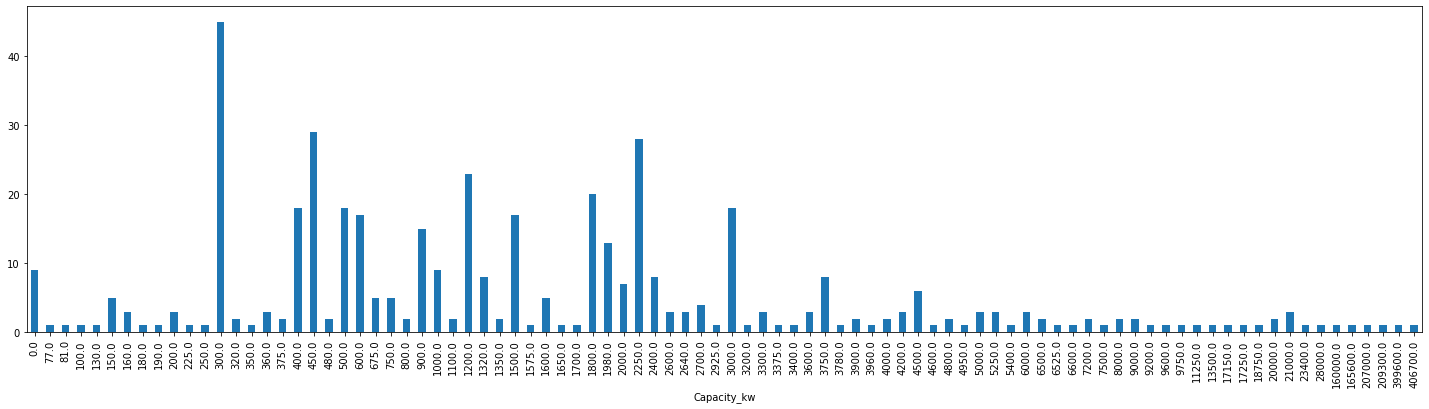

In [47]:
plt.figure(figsize=(25,6))
windmills[windmills['Turbine_type']=='P'].groupby("Capacity_kw")["GSRN"].count().plot.bar()

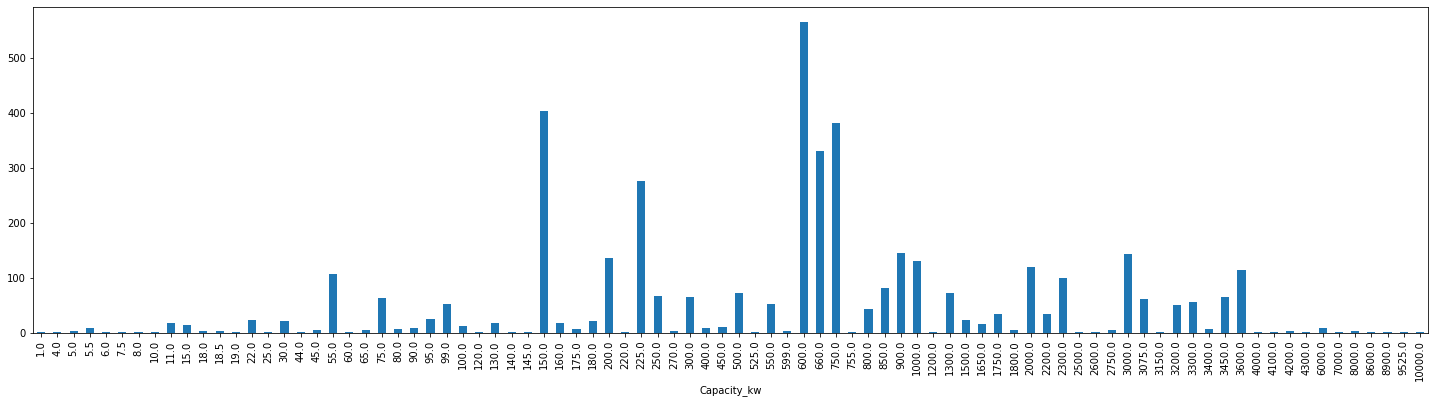

In [49]:
plt.figure(figsize=(25,6))
windmills[windmills['Turbine_type']=='W'].groupby("Capacity_kw")["GSRN"].count().plot.bar()

In [48]:
windmills[windmills['Turbine_type']=='P']

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,grid,grid_in_range,Land_cover,Slope,roughness
1341,570714700000050008,P,NaN,390.0,LAND,684100.400000,6.097951e+06,3750.0,NaN,NaN,690,"730,731,773,690,691,774,733,689,732,688,646,60...",190.0,0.000000,1.0
1342,570714700000050015,P,NaN,360.0,HAV,636349.972727,6.093533e+06,4950.0,NaN,NaN,815,"855,813,771,856,729,730,814,731,773,815,857,85...",210.0,-1.000000,0.0
1343,570714700000050022,P,NaN,250.0,LAND,682023.809524,6.188402e+06,3780.0,NaN,NaN,737,"735,693,819,820,778,736,777,821,780,781,822,69...",11.0,2.263636,0.1
1344,570714700000050039,P,NaN,316.0,LAND,674395.333333,6.184767e+06,600.0,NaN,NaN,779,"735,693,862,819,820,778,736,777,821,863,780,82...",11.0,1.432096,0.1
1345,570714700000050046,P,NaN,316.0,LAND,674289.000000,6.184966e+06,400.0,NaN,NaN,779,"735,693,862,819,820,778,736,777,821,863,780,82...",11.0,0.000000,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,570715000000055638,P,NaN,NaN,NaN,504163.000000,6.277061e+06,NaN,NaN,NaN,1243,"1283,1241,1326,1285,1284,1199,1158,1242,1202,1...",70.0,2.263636,1.5
9978,570715000000056017,P,NaN,NaN,NaN,468672.240000,6.145816e+06,NaN,NaN,NaN,1235,"1233,1191,1275,1195,1318,1276,1235,1192,1150,1...",10.0,0.000000,0.1
9979,570715000000056857,P,NaN,NaN,NaN,513111.100000,6.320199e+06,NaN,NaN,NaN,1246,"1202,1244,1330,1331,1329,1245,1328,1286,1246,1...",130.0,1.432096,0.1
9980,570715000000056918,P,NaN,NaN,NaN,514683.070000,6.320302e+06,NaN,NaN,NaN,1246,"1202,1244,1330,1331,1329,1245,1328,1286,1246,1...",130.0,0.000000,0.1


### Capacity Interval

In [157]:
def get_interval(k, order):
    sub_count = sum(order['Count']) // k
    interval = {}
    accu = 0
    for index, item in order.iterrows():
        accu += item['Count']
        if accu >= sub_count:
            interval[item['Key']]= accu
            accu = 0
        elif index == len(order)-1:
            interval[item['Key']]= accu
    return sub_count, interval

In [151]:
order_P = windmills[windmills['Turbine_type']=='P'].groupby("Capacity_kw")["GSRN"].count().reset_index().rename(columns = {"GSRN": "Count","Capacity_kw":"Key"}) 
sub_count_P, interval_P = get_interval(4, order_P)
sub_count_P, interval_P

(111, {450.0: 128.0, 1500.0: 125.0, 3000.0: 113.0, 406700.0: 78.0})

In [152]:
order_W = windmills[windmills['Turbine_type']=='W'].groupby("Capacity_kw")["GSRN"].count().reset_index().rename(columns = {"GSRN": "Count","Capacity_kw":"Key"}) 
sub_count_W, interval_W = get_interval(6, order_W)
sub_count_W, interval_W

(699,
 {150.0: 830.0,
  550.0: 746.0,
  660.0: 897.0,
  1000.0: 782.0,
  3300.0: 726.0,
  10000.0: 214.0})

In [156]:
windmills[windmills['Turbine_type']=='W'].groupby("roughness")["GSRN"].count()

roughness
0.000       56
0.005        1
0.100     3778
0.300      265
1.000       24
1.500       48
11.000      23
Name: GSRN, dtype: int64

In [155]:
windmills[windmills['Turbine_type']=='W'].groupby("Slope")["GSRN"].count()

Slope
-1.000000       13
 0.000000     1590
 1.012750      496
 1.432096      284
 2.024868       94
 2.263636      459
 2.862405      325
 3.035724      208
 3.199601      315
 3.646971       59
 4.044691       44
 4.168740       61
 4.289154       19
 4.520227       21
 5.051153       29
 5.150652       35
 5.438008       12
 5.710593       16
 5.885129       17
 6.054499        8
 6.137380        7
 6.379370       14
 6.457955        9
 6.762861        4
 7.054132        7
 7.125016        2
 7.264627        3
 7.333393        2
 7.667577        3
 7.860959        4
 8.049467        2
 8.111279        8
 8.293805        4
 8.530766        1
 8.588925        3
 8.646670        4
 9.256682        1
 9.520203        1
 10.073967       1
 10.779772       1
 11.048352       1
 11.309933       1
 11.690208       1
 12.017035       2
 12.334205       1
 12.942409       1
 13.089463       1
 15.345950       1
Name: GSRN, dtype: int64

# Settlement

In [90]:
settlement = pq.read_table('data/ITU_DATA/settlement/2019.parquet')

In [94]:
settlement = settlement.to_pandas()

In [122]:
single_windmill = settlement[settlement["GSRN"] == "571313174001764448"]

In [124]:
single_windmill = single_windmill[single_windmill['TIME_CET'].str[5:7] == '12']

In [125]:
single_windmill

,GSRN,TS_ID,VAERDI,TIME_CET
142379785,571313174001764448,50200502,0,2019-12-01 00:00:00
142379786,571313174001764448,50200502,0,2019-12-01 01:00:00
142379787,571313174001764448,50200502,0,2019-12-01 02:00:00
142379788,571313174001764448,50200502,0,2019-12-01 03:00:00
142379789,571313174001764448,50200502,0,2019-12-01 04:00:00
...,...,...,...,...
154124102,571313174001764448,50200502,0,2019-12-30 20:00:00
154124103,571313174001764448,50200502,0,2019-12-30 21:00:00
154124104,571313174001764448,50200502,0,2019-12-30 22:00:00
154124105,571313174001764448,50200502,0,2019-12-30 23:00:00


In [131]:
test = single_windmill[["VAERDI", "TIME_CET"]]

In [132]:
test["VAERDI"] = test["VAERDI"].astype(float)

In [129]:
test = test[test["TIME_CET"].str[5:10]=="12-01"]

In [133]:
test

,VAERDI,TIME_CET
142379785,0.0,2019-12-01 00:00:00
142379786,0.0,2019-12-01 01:00:00
142379787,0.0,2019-12-01 02:00:00
142379788,0.0,2019-12-01 03:00:00
142379789,0.0,2019-12-01 04:00:00
...,...,...
154124102,0.0,2019-12-30 20:00:00
154124103,0.0,2019-12-30 21:00:00
154124104,0.0,2019-12-30 22:00:00
154124105,0.0,2019-12-30 23:00:00


In [77]:
import matplotlib.pyplot as plt

In [137]:
plt.figure(figsize=(30,6))
plt.plot(test["TIME_CET"], test["VAERDI"])

Error in callback <function flush_figures at 0x86fae4f28> (for post_execute):


KeyboardInterrupt: 

In [134]:
test[test["VAERDI"] == 0].count()

VAERDI      486
TIME_CET    486
dtype: int64

In [135]:
test[test["VAERDI"] != 0].count()

VAERDI      235
TIME_CET    235
dtype: int64

In [139]:
test[test["VAERDI"] == 0].count() / test.count() * 100

VAERDI      67.40638
TIME_CET    67.40638
dtype: float64